# Symbolic Quantum Library & Phase Estimation Demo
## Danny Foster, 2023

The following notebook contains a basic library I created to show the effects of acting certain operators on two-level quantum systems in the computational basis. In addition to showing example uses of this library, the rest of the notebook contains some examples that I used to to get more intuition for the quantum phase estimation algorithm (QPE).

<center><h3>The Symbolic Simulator Code</h3></center>


In [323]:
import sympy as sy
import numpy as np
import matplotlib.pyplot as plt
from sympy.physics.quantum import Ket



imag = sy.I
pi = sy.pi


gates = {"H":{"0":{"0":1/sy.sqrt(2),"1":1/sy.sqrt(2)}, 
                     "1":{"0":1/sy.sqrt(2),"1":-1/sy.sqrt(2)}},
                "X":{"0":{"1":1},"1":{"0":1}},
                "Y":{"0":{"1":-imag},"1":{"0":imag}},
                "Z":{"0":{"0":1},"1":{"1":-1}},
                "P":{"0":{"0":1}, "1":{"1":"sy.exp(imag*parameter)"}}
               }


'''
Used to convert a decimal number to its corresponding quantum state
represented as a binary number. I keep the most-significant bit (MSB)
to the left when written out and as the top quantum register
when drawn as a circuit. Similarly, the LSB will be the right-most
digit and bottom quantum register.
'''
def dec_to_binary(dec, n_wires):
    if (type(dec) == int or type(dec) == float):
        binary = "{0:b}".format(int(dec))
        dl = n_wires - len(binary)
        binary = "0"*dl + binary
    else:
        binary = dec
    return binary


to_dec = lambda bin_str : int(bin_str, 2)


'''
Each quantum state is an instance of the QState class.
A QState object is instantiated by passing on the number of registers.
After instantiation, the initial (pure) state can be defined by passing
a (normalized) state as a dictionary. Different methods can be called
to act different operators on the states.
'''
class QState:
    def __init__(self, n_wires):
        self.n = n_wires
        self._state = {dec_to_binary(0, n_wires):1}
    
    
    @property
    def state(self):
        return self._state
        
    
    
    @state.setter
    def state(self, s):
        if type(s) != dict:
            self._state = {dec_to_binary(s, self.n):1}
        else:
            self._state = {dec_to_binary(key, self.n):s[key] for key in s}
    
    
    '''
    Display the 'current' quantum state. 
    Represents the wavefunction of the state.
    
    Passing the argument 'numb=True' returns the state with the 
    coefficients returned numerically (not valid for gates with a 
    parameter defined symbolically, i.e. passing a phase of variable 
    "phi").
    '''
    def disp(self, numb=False):
        my_keys = sorted(self._state)
        expression = 0
        for i in my_keys:
            if numb:
                expression += self._state[i].evalf() * Ket(i)
            else:
                expression += sy.expand(self._state[i]) * Ket(i)
        return sy.simplify(expression)
    
    
    '''
    Swaps the two registers s1 and s2. Unlike other operations,
    this gate must be called directly. (Not through the single_gate
    or controlled_gate methods.)
    '''
    def swap(self, s1, s2):
        if s1 != s2:
            string_swap = lambda string,i,j : string[0:min(i,j)] +\
            string[max(i,j)] + string[min(i,j)+1:max(i,j)]\
            + string[min(i,j)] + string[max(i,j) + 1::]
            new_state = {string_swap(string, s1, s2):self.state[string] for string in self.state}
            self.state = new_state
    
    
    '''
    This method is used to call any gate that acts on a single register.
    For gates that take a parameter (like 'Phase'), the parameter
    can be passed as an optional argument or with the keyword 
    "Parameter".
    
    By default, this method will modify the 'state'. However passing 'update=False',
    allows the user to see how a gate would act on a state without
    changing the 'state'.
    '''
    def single_gate(self, gate_key, position, *param, **kwargs):
        new_state = {}
        if ("update" not in kwargs):
            update = True
        else:
            update = kwargs["update"]
        if not param:
            if "Parameter" in kwargs:
                parameter = kwargs["Parameter"]
        else:
            parameter=param[0]
        old_state = self.state
        for component in old_state:
            value = component[position]
            multiplier = old_state[component]
            first_string = component[:position]
            last_string = component[position+1::]
            for basis in gates[gate_key][value]:
                new_component = first_string + basis + last_string
                operation = gates[gate_key][value][basis]
                if type(operation) == str:
                    operation = eval(operation)
                coefficient = multiplier * operation
                if new_component in new_state:
                    new_state.update({new_component:new_state[new_component] + coefficient})
                else:
                    new_state.update({new_component:coefficient})
        if update:
            self.state = new_state
        else:
            return new_state
    
     
    
    '''
    This method is used to call any gate with a single control register and 
    a single target register (i.e. a CNOT gate, but not a Toffoli gate.)
    For gates that take a parameter (like 'CPhase'), the parameter
    can be passed as an optional argument or with the keyword 
    "Parameter".
    
    The 'update' keyword can be used in this method in the same way
    that it is used in the 'single_gate' method.
    '''
    def controlled_gate(self, gate_key, target_pos, control_pos, *param, **kwargs):
        new_state = {}
        if ("update" not in kwargs):
            update = True
        else:
            update = kwargs["update"]
        if not param:
            if "Parameter" in kwargs:
                parameter = kwargs["Parameter"]
        else:
            parameter = param[0]
        old_state = self.state
        for component in old_state:
            control_val = component[control_pos]
            if (control_val == "1"):
                target_val = component[target_pos]
                multiplier = old_state[component]
                first_string = component[:target_pos]
                last_string = component[target_pos+1::]
                for basis in gates[gate_key][target_val]:
                    new_component = first_string + basis + last_string
                    operation = gates[gate_key][target_val][basis]
                    if type(operation) == str:
                        operation = eval(operation)
                    coefficient = multiplier * operation
            else:
                new_component = component
                multiplier = old_state[component]
                coefficient = multiplier
            if new_component in new_state:
                new_state.update({new_component:new_state[new_component] + coefficient})
            else:
                new_state.update({new_component:coefficient})
        if update:
            self.state = new_state
        else:
            return new_state

        
    '''
    Acts a series of operations (passed in the list 'circ') on the state.
    For more information about how formatting inputs read:
    https://github.com/0dannyboi/0dannyboi.github.io/blob/master/QuantumFolder/Projects/SimpleQuantumUnitary.py
    '''
    def evaluate(self, circ):
        for line in circ:
            kwargs = {}
            if "@" in line: # finds parameter (if existing)
                gate = line[0:line.index("@")]
                parameter = line[line.index("@")+1:line.index(",")]
                kwargs.update({"Parameter":eval(parameter)})
                if gate == "S":
                    target = int(line[line.index(",")+1::].strip())
                    self.swap(target, int(parameter))
                    break
            else:
                gate = line[0:line.index(",")]
            wires = line[line.index(",")+1::]
            if ("->" in line): # finds control and target (if gate is controlled)
                control = int(wires[:wires.index("->")].strip())
                target = int(wires[wires.index("->")+2:].strip())
                kwargs.update({"Control":control})
                self.controlled_gate(gate, target, control, **kwargs)
            else: # target when there is no control (a single gate)
                target = int(wires.strip())
                self.single_gate(gate, target, **kwargs)

                
'''
Returns the list of gates to perform the inverse quantum Fourier 
transform on the uppermost n_qubits.
'''                
def iqft(n_qubits):
    n_qubits -= 1
    gates = []
    for i in range(n_qubits):
        gates.append("H, " + str(i))
        for j in range(0, n_qubits - i):
            phase = str(-np.pi / (2**(j+1)))
            gates.append("P@" + str(phase) + ", " + str(i) + "->" + str(1 + j + i))
    gates.append("H, " + str(n_qubits))
    for i in range(0, (n_qubits) // 2 + 1):
        q1 = i
        q2 = n_qubits - i
        if (q2 != q1):
            gates.append("S@" + str(q1) + ", " + str(q2))
    return gates


'''
Returns the list of gates to perform the quantum Fourier 
transform on the uppermost n_qubits.
'''    
def qft(n_qubits):
    n_qubits -= 1
    gates = []
    for i in range(0, (n_qubits) // 2 + 1):
        q1 = i
        q2 = n_qubits - i
        if (q2 != q1):
            gates.append("S@" + str(q1) + ", " + str(q2))
    for i in range(n_qubits):
        gates.append("H, " + str(n_qubits - i))
        for j in range(n_qubits - i):
            phase = str(pi / (2**(j+1)))
            gates.append("P@" + str(phase) + ", " + str(n_qubits - i) + "->" + str(n_qubits -  j - i - 1))
    gates.append("H, 0")
    return gates


var = lambda x :sy.symbols(x) # creates a symbol from a string

## Simple Examples of Library


What does a Hadamard gate do to a single qubit in the state $|0⟩$?

First, we create an instance of QState:

In [42]:
QS = QState(1)

We can see that the state is always initialized as $0$ in the corresponding binary representation. 

In [38]:
QS.disp()

|0>

Internally, it is represented as a dictionary:

In [39]:
QS.state

{'0': 1}

Now, back to the Hadamard gate:

In [43]:
QS.single_gate("H", 0)
QS.disp()

sqrt(2)*(|0> + |1>)/2

What if we apply another Hadamard gate?

In [44]:
QS.single_gate("H", 0)
QS.disp()

|0>

Because quantum gates are unitary, we expect that the application of two Hadamard gates on a state $|\psi⟩$ to be: 
$H$ $H$ $|\psi⟩$ = $|\psi⟩$.
<br><br>
Where a unitary operator, $U$, satisfies:
<br>
$$U U^{\dagger} = U^{\dagger} U = \mathbb{1}$$

For the Hadamard gate, we can represent it as the following matrix:
$$H = H^{\dagger} = \frac{1}{\sqrt{2}}\begin{bmatrix} 1 & 1 \\ 1 & -1  \end{bmatrix}$$

It is easy to verify that the matrix representation is, indeed, unitary:

$$H^{\dagger}H = H H^{\dagger} = \mathbb{1}$$
 

In [71]:
H_mat = 1/np.sqrt(2) * np.array([[1, 1], [1, -1]])
H_dagger = np.conjugate(H_mat.T)
if np.allclose(H_mat, H_dagger):
    display(Latex("$H = H^{\dagger}$"))
if np.allclose(H_mat@H_dagger, np.eye(2)):
    display(Latex("$H H^{\dagger} = \mathbb{1}$"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

So we can see the code works in the case of a gate with a matrix representation containing strictly real elements. 

Let's see consider a slightly less trivial case where the operator is not Hermitian. For example, we can consider the phase gate, $P_\phi$ on an arbitrary phase $\phi$. Let's define a symbol $\phi$:

In [73]:
phi = var("\\phi")
phi

\phi

A phase gate, $P_{\phi}$, acting on a single qubit performs the following mapping:
$$P_{\phi} |0⟩ \xrightarrow{} |0⟩,$$
$$P_{\phi} |1⟩ \xrightarrow{} e^{i\phi}|1⟩$$
And the matrix representation is:

$$P_{\phi} = \begin{bmatrix} 1 & 0 \\ 0 & e^{i\phi}  \end{bmatrix}$$

So to see anything interesting, we will get our qubit in $|1⟩$ by passing a dictionary:

In [74]:
QS.state = {1:1}
QS.single_gate("P", 0, Parameter=phi)
QS.disp()

exp(I*\phi)*|1>

Because we have a complex term in $P_{\phi}$ (unlike with $H$), we can expect that the following is <i><b>not true</b></i>:
$$P_{\phi} P_{\phi} = \mathbb{1}$$

To check, we find:

In [75]:
QS.single_gate("P", 0, Parameter=phi)
QS.disp()

exp(2*I*\phi)*|1>

The inverse will be the conjugate transpose, which is equivalent to the phase gate with the phase multiplied by $-1$, or $P_{-\phi}$ :
$$P_{\phi}^{\dagger} = \begin{bmatrix} 1 & 0 \\ 0 & e^{-i\phi}  \end{bmatrix} = P_{-\phi}$$

In [92]:
QS.state = {1:1}
QS.single_gate("P", 0, Parameter=phi)
QS.disp()

exp(I*\phi)*|1>

With $P_{-\phi}$ acting on the state $e^{𝑖𝜙}|1⟩$ :

In [93]:
QS.single_gate("P", 0, Parameter=-phi)
QS.disp()

|1>

Just as expected.
<br><br>
In addition, we can pass a list of gates onto an instance of QState.

One interesting example is in the creation of one of the maximally-entangled Bell States, $|\Phi_{+}⟩$:

$$|\Phi_{+}⟩ = \frac{1}{\sqrt{2}} \left[|00⟩ + |11⟩ \right]$$

This state can be created from $|00⟩$ by acting a Hadamard gate on one of the registers and then using the same register to control an $X$ (NOT) gate on the other register. We can use Qiskit to visualize the circuit:

In [97]:
import qiskit

qc = qiskit.QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.draw()

┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘

In [103]:
my_gates = ["H, 0", "X, 0->1"]
my_state = QState(2)
print("Initial State:")
display(my_state.disp())
my_state.evaluate(my_gates)
print("Final State:")
my_state.disp()

Initial State:


|00>

Final State:


sqrt(2)*(|00> + |11>)/2

## Quantum Phase Estimation Algorithm & Motivation

Let's say we have a particular unitary operator, $U$ (i.e. a quantum gate or series of quantum gates), and we know that a particular state, $|\Lambda⟩$, is an eigenvector of $U$ such that:
$$U|\Lambda⟩ = \lambda |\Lambda⟩ $$
for an eigenvalue $\lambda$. Additionally, as $U$ is unitary, for any one of its eigenvalues $\lambda_i$, $\lambda_i * \lambda_i^{*} = 1$, or equivalently, all eigenvalues have an absolute value of $1$. Therefore, we can express the eigenvalues in terms of a complex phase:
$$\lambda = e^{2 \pi i \theta} $$
<br>
QPE provides a method of estimating $\lambda$ to an arbitrary finite precision given an eigenvector, $|\Lambda⟩$.

We will consider the case of $U = P_{\theta}$ because it requires only a single qubit.

We already know that $|1⟩$ is an eigenvector with a corresponding eigenvalue of $e^{i \phi}$, making it simple to check our proposed estimation scheme as we test it out.
<br><br>
We will build up to the QPE algorithm by seeking a way to approximate the phase $\theta$ as a sum of smaller contributions, $m * \delta \theta$ for a range integers, $m$. After that, we will need a way to extract values from our results.

### Aside: the unit circle and fractional binary representations

As complex numbers which admit the form $e^{i\phi}$ lie on the unit circle of the complex plane, it is sufficient to only consider values $0 \leq \phi < 2 \pi$.

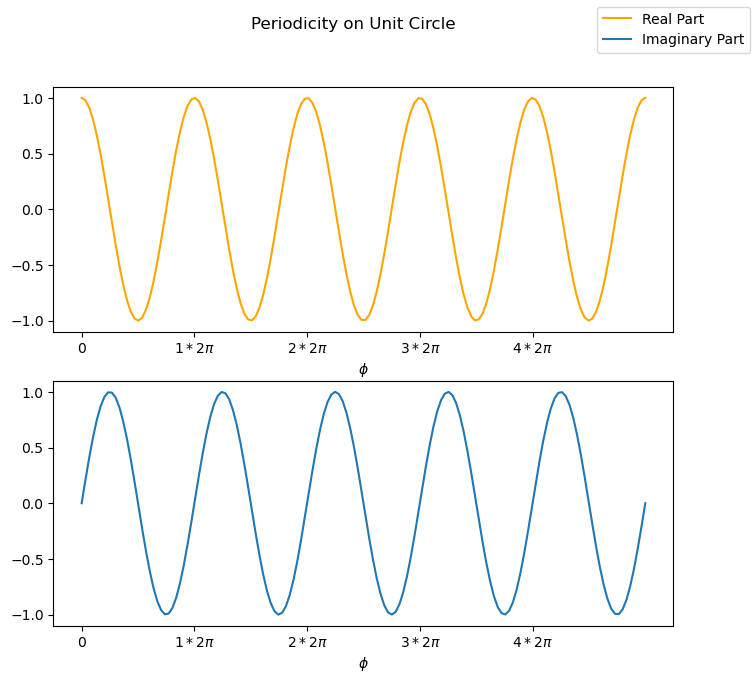

In [141]:
fig, axs = plt.subplots(2, 1, figsize=(8,7))
fig.suptitle("Periodicity on Unit Circle")
x_range = np.linspace(0, 5 * 2 * np.pi, 150)
dat = np.exp(1j * x_range)
my_ticks = 2 * pi * np.arange(0, 5)
tick_labels = ["$0$", "$1*2\pi$", "$2*2\pi$", "$3*2\pi$", "$4*2\pi$"]
axs[0].plot(x_range, np.real(dat),c="orange", label="Real Part")
axs[0].set_xticks(my_ticks, tick_labels)
axs[1].plot(x_range, np.imag(dat), label="Imaginary Part")
axs[1].set_xticks(my_ticks, tick_labels)
axs[0].set_xlabel("$\phi$")
axs[1].set_xlabel("$\phi$")
fig.legend()

Now that we have demonstrated that it is sufficient to find a value $\phi$ with $0 \leq \phi < 2 \pi$ to find our eigenvalue, $\lambda$, we can simplify the terms. Instead of being interested in $\phi$, we can look for a value $\theta$, such that $0\leq \theta < 1$, where $\phi = 2\pi \theta$.

Given $m$ bits, we can approximate an arbitrary fraction, $f$ as:

$$f \approx \sum_{i=1}^{m} a_i \cdot 2^{-m}$$

For fractions that are exactly equal to sums of terms of the form $2^{-m}$ it is straightforward:
$$\frac{1}{2} = 2^{-1}=0.1$$
Where $0.1$ is the fraction's binary representation.
<br><br>
Additionally:
$$ \frac{3}{4} = 2^{-1} + 2^{-2} = 0.11$$

Interestingly, fractions will only terminate in a binary representation if the denominator is a power of 2. This makes it difficult to represent numbers such as $3/5$:
$$\frac{3}{5}\to0.100110011001100...$$
By using $n$ bits, we have a precision of $2^{-n}$.
<br><br>
To illustrate this point, consider the code below:

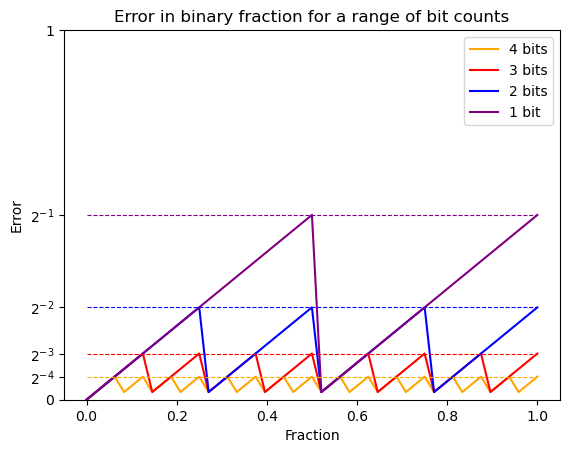

In [161]:
'''
This code uses 'Binary Fractions' library, you
may need to run 'pip install binary-fractions' in
your terminal.
'''
from binary_fractions import Binary

def remove_dec(b): # turns binary fraction from '0.101011 to 101011'; removes '0.' from string
    b = str(b)
    if ("0." in b):
        b = b.replace("0.", "")
    elif ("." in b):
        b = b.replace(".", "")
    return b

def bin_to_dec_frac(b): # turns a binary fraction (LESS THAN 1) to a decimal float
    b = remove_dec(b)
    l = len(b)
    tot = 0
    for i in range(l):
        tot += int(b[i])*(2**-(1+i))
    return tot


def error(frac, n_bits): # computes the error in the form of (decimal value - binary value) for an arbitrary bit count
    b = remove_dec(Binary(frac).string)[:n_bits]
    return frac - bin_to_dec_frac(b)

# produce a range of fractional values, 0 <= x < 1:
x_vals = np.linspace(0, 1-0.0001, 49)

plt.figure()
plt.title("Error in binary fraction for a range of bit counts")
plt.plot(x_vals, [error(h, 4) for h in x_vals],c="orange",label="4 bits")
plt.plot(x_vals, [error(h, 3) for h in x_vals],c="red",label="3 bits")
plt.plot(x_vals, [error(h, 2) for h in x_vals],c="blue", label="2 bits")
plt.plot(x_vals, [error(h, 1) for h in x_vals],c="purple", label="1 bit")

plt.plot([0, 1], [1/(2**4), 1/(2**4)],c="orange", linestyle="dashed",linewidth=0.8)
plt.plot([0, 1], [1/(2**3), 1/(2**3)],c="red", linestyle="dashed",linewidth=0.8)
plt.plot([0, 1], [1/(2**2), 1/(2**2)],c="blue",linestyle="dashed",linewidth=0.8)
plt.plot([0, 1], [1/(2**1), 1/(2**1)],c="purple", linestyle="dashed",linewidth=0.8)
plt.ylim(0,1)
plt.ylabel("Error")
plt.xlabel("Fraction")
plt.yticks([0, 1/16, 1/8, 1/4, 1/2, 1], ["0", "$2^{-4}$", "$2^{-3}$", "$2^{-2}$", "$2^{-1}$", "1"])
plt.yticks([0, 1/16, 1/8, 1/4, 1/2, 1])

plt.legend()
plt.show()

### Discrete Fourier Transform (DFT) and Quantum Fourier Transform  (QFT)

Given a sequence of $N$ complex numbers, $\{f_0, f_1, f_2, f_3, ..., f_{N-1}\}$, we can determine the contribution of periodic functions of different frequencies by computing the DFT of the set. The discrete Fourier transform evaluated for index n, $F_n$ is:
$$F_n = \sum_{k=0}^{N-1} f_k e^{-2\pi i n k / N}$$



Similarly, we can extend the analogy to quantum states. In this case, the sign convention is different, so the analogous expression above is the inverse quantum Fourier transform for index $n$:

$$|x_n⟩ = \frac{1}{\sqrt{N}} \sum_{k=0}^{N-1} |\tilde{x}_k⟩ e^{-2\pi i n k / N} $$

So now that we have an expression for the IQFT, let's work out its values for an example.

<h3>2 Qubits:</h3>
<br>
Let the system be in the state $|\psi⟩ = \alpha_0|00⟩ + \alpha_1|01⟩ + \alpha_2|10⟩+ \alpha_3|11⟩ = |\tilde{x}_0⟩ + |\tilde{x}_1⟩ + |\tilde{x}_2⟩+ |\tilde{x}_3⟩$. Evaluating our sums for this state:

$$|x_n⟩ = \frac{1}{\sqrt{2^2}} \sum_{k=0}^{3} |\tilde{x}_k⟩ e^{-2\pi i n k / 4}$$

$$|x_0⟩ = \frac{1}{\sqrt{2^2}} e^{0} \left( |\tilde{x}_0⟩ + |\tilde{x}_1⟩ + |\tilde{x}_2⟩+ |\tilde{x}_3⟩ \right)$$

$$|x_1⟩ = \frac{1}{\sqrt{2^2}}  \left( e^{-i 2 \pi * 0 * 1/ 4}|\tilde{x}_0⟩ +e^{-i 2 \pi * 1 * 1 / 4} |\tilde{x}_1⟩ + e^{-i 2 \pi * 1 * 2 / 4} |\tilde{x}_2⟩+ e^{-i 2 \pi * 1 * 3 / 4}|\tilde{x}_3⟩ \right)$$

$$|x_2⟩ = \frac{1}{\sqrt{2^2}}  \left( e^{-i 2 \pi * 0 / 4}|\tilde{x}_0⟩ +e^{-i 2 \pi * 1 * 2 / 4} |\tilde{x}_1⟩ + e^{-i 2 \pi * 2* 2 / 4} |\tilde{x}_2⟩+ e^{-i 2 \pi* 2 * 3 / 4}|\tilde{x}_3⟩ \right)$$

$$|x_3⟩ = \frac{1}{\sqrt{2^2}}  \left( e^{-i 2 \pi * 0 / 4}|\tilde{x}_0⟩ +e^{-i 2 \pi * 1 * 3 / 4} |\tilde{x}_1⟩ + e^{-i 2 \pi * 2* 3 / 4} |\tilde{x}_2⟩+ e^{-i 2 \pi* 3 * 3 / 4}|\tilde{x}_3⟩ \right)$$

Which simplifies to:

$$|x_0⟩ = \frac{|\tilde{x}_0⟩ + |\tilde{x}_1⟩ + |\tilde{x}_2⟩+ |\tilde{x}_3⟩}{2}$$

$$|x_1⟩ = \frac{|\tilde{x}_0⟩ - i |\tilde{x}_1⟩ - |\tilde{x}_2⟩ + i |\tilde{x}_3⟩}{2}$$

$$|x_2⟩ = \frac{|\tilde{x}_0⟩ - 1 |\tilde{x}_1⟩ + |\tilde{x}_2⟩ - 1 |\tilde{x}_3⟩}{2}$$

$$|x_3⟩ = \frac{|\tilde{x}_0⟩ + i|\tilde{x}_1⟩ - |\tilde{x}_2⟩ - i |\tilde{x}_3⟩}{2}$$

In general, the circuits for IQFT can be constructed as follows:

In [201]:

'''
2 Qubits
     ┌───┐                  
𝑥̃_0: ┤ H ├─■──────────────X─
     └───┘ │P(-π/2) ┌───┐ │ 
𝑥̃_1: ──────■────────┤ H ├─X─
                    └───┘   
'''

'''
3 Qubits
     ┌───┐                                           
𝑥̃_0: ┤ H ├─■─────────■─────────────────────────────X─
     └───┘ │P(-π/2)  │        ┌───┐                │ 
𝑥̃_1: ──────■─────────┼────────┤ H ├─■──────────────┼─
                     │P(-π/4) └───┘ │P(-π/2) ┌───┐ │ 
𝑥̃_2: ────────────────■──────────────■────────┤ H ├─X─
                                             └───┘
'''
'''
4 Qubits
     ┌───┐                                                            »
q_0: ┤ H ├─■─────────■──────────────■─────────────────────────────────»
     └───┘ │P(-π/2)  │        ┌───┐ │                                 »
q_1: ──────■─────────┼────────┤ H ├─┼─────────■─────────■─────────────»
                     │P(-π/4) └───┘ │         │P(-π/2)  │        ┌───┐»
q_2: ────────────────■──────────────┼─────────■─────────┼────────┤ H ├»
                                    │P(-π/8)            │P(-π/4) └───┘»
q_3: ───────────────────────────────■───────────────────■─────────────»
                                                                      »                       
«q_0: ────────────────X─
«                     │ 
«q_1: ────────────X───┼─
«                 │   │ 
«q_2: ─■──────────X───┼─
«      │P(-π/2) ┌───┐ │ 
«q_3: ─■────────┤ H ├─X─
«               └───┘   
                                             
'''
0

0

We can verify that this circuit performs the actions described by the IQFT on a two-qubit register. When we run the following code below, we are initializing a 2 qubit circuit into the state $|\psi⟩ = \alpha_0|00⟩ + \alpha_1|01⟩ + \alpha_2|10⟩+ \alpha_3|11⟩ = |\tilde{x}_0⟩ + |\tilde{x}_1⟩ + |\tilde{x}_2⟩+ |\tilde{x}_3⟩$. <br><br>
After that, we apply a series of Hadamard and controlled phase gates consistent with the structure of the two-qubit IQFT circuit above. Then we apply a swap to get the ordering to be correct

In [196]:
QS=QState(2)
QS.state = {0:var("\\alpha_0"), 1:var("\\alpha_1") ,2:var("\\alpha_2"), 3:var("\\alpha_3")}
QS.single_gate("H",0)
QS.controlled_gate("P", 1, 0, -pi/2)
QS.single_gate("H", 1)
print("Before Swap")
display(QS.disp())
print("After Swap")
QS.swap(0, 1)
display(QS.disp())

Before Swap


((\alpha_0 - \alpha_1 + \alpha_2 - \alpha_3)*|01> + (\alpha_0 + \alpha_1 + \alpha_2 + \alpha_3)*|00> + (\alpha_0 - I*\alpha_1 - \alpha_2 + I*\alpha_3)*|10> + (\alpha_0 + I*\alpha_1 - \alpha_2 - I*\alpha_3)*|11>)/2

After Swap


((\alpha_0 - \alpha_1 + \alpha_2 - \alpha_3)*|10> + (\alpha_0 + \alpha_1 + \alpha_2 + \alpha_3)*|00> + (\alpha_0 - I*\alpha_1 - \alpha_2 + I*\alpha_3)*|01> + (\alpha_0 + I*\alpha_1 - \alpha_2 - I*\alpha_3)*|11>)/2

This closely matches our expected result of: 

$$|x_0⟩ = \frac{|\tilde{x}_0⟩ + |\tilde{x}_1⟩ + |\tilde{x}_2⟩+ |\tilde{x}_3⟩}{2} \to \frac{\alpha_0 + \alpha_1 + \alpha_2 + \alpha_3}{2} |00⟩$$


$$|x_1⟩ = \frac{|\tilde{x}_0⟩ - i |\tilde{x}_1⟩ - |\tilde{x}_2⟩ + i |\tilde{x}_3⟩}{2} \to \frac{\alpha_0 -i \alpha_1 - \alpha_2 + i \alpha_3}{2} |01⟩ $$

$$|x_2⟩ = \frac{|\tilde{x}_0⟩ - 1 |\tilde{x}_1⟩ + |\tilde{x}_2⟩ - 1 |\tilde{x}_3⟩}{2} \to \frac{\alpha_0 -\alpha_1 + \alpha_2 - \alpha_3}{2} |10⟩$$

$$|x_3⟩ = \frac{|\tilde{x}_0⟩ + i|\tilde{x}_1⟩ - |\tilde{x}_2⟩ - i |\tilde{x}_3⟩}{2} \to \frac{\alpha_0 + i \alpha_1 - i \alpha_2 - i \alpha_3}{2} |11⟩$$

## Putting it together
Now we have a method to consistently return linear combinations of our basis states weighted by the input coefficients and roots of unity. 
<br><br>
Recall that our end goal is to estimate the phase associated with an arbitrary eigenvalue for some unitary operator given its associated eigenvector. We need some method that allows us to break apart the phase of the eigenvalue into a binary fraction expansion that the IQFT can process.

We need to have a basis that can span a range of values.
For a single qubit, it spans the set of values $\{0, 1\}$. A two-qubit register spans the set of values $\{0, 1, 2, 3\}$, etc.
<br><br>
We can use a Hadamard gate on each of the top registers to form a superposition state spanning all $2^{N}$ basis vectors. Now we just need an algorithm to put the states in a form the IQFT can use.

In [203]:
'''
           ┌───┐      ┌───────────────┐                                       ┌───────────────┐                
PE_0:      ┤ H ├──────┼───────────────┼─────────────────────────────────────» ┼───────────────┼
           └───┘      │ Gates to 'put'│                                       │     IQFT      │
           ┌───┐      │ 𝜆 phase  on   │                                       │               │                              
PE_1:      ┤ H ├──────┼───────────────┼─────────────────────────────────────» ┼───────────────┼
    .      └───┘      │ top wires.    │                                     . │       .       │ 
    .                 │       .       │                                     . │       .       │ 
    .      ┌───┐      │       .       │                                     . │       .       │
PE_(N-1):  ┤ H ├──────┼───────────────┼─────────────────────────────────────» ┼───────────────┼    
           └───┘      └───────┼───────┘                                       └───────────────┘
                              |
                              |
                              |
                      ┌───────┼───────┐
  ┌────┐:─────────────┼───────────────┼────────────────────────────────────»
  ||Λ> |              │ Gates to 'put'│                 
  |    |:─────────────┼───────────────┼────────────────────────────────────»
  |    |    .         │ top wires.    │
  |    |    .         │       .       │
  |    |    .         │       .       │
  └────┘:─────────────┼───────────────┼─────────────────────────────────────»
  Eigenvector         └───────────────┘
'''    
0

0

It turns out that the QPE algorithm imparts information about the phase corresponding to an eigenvector on the bottom register by applying a series of controlled phase operations a number of times onto each qubit, depending on its index.

The schematic is shown below (image courtesy of <a href = "https://commons.wikimedia.org/wiki/File:PhaseCircuit-crop.svg">Omrica on Wikimedia</a>):

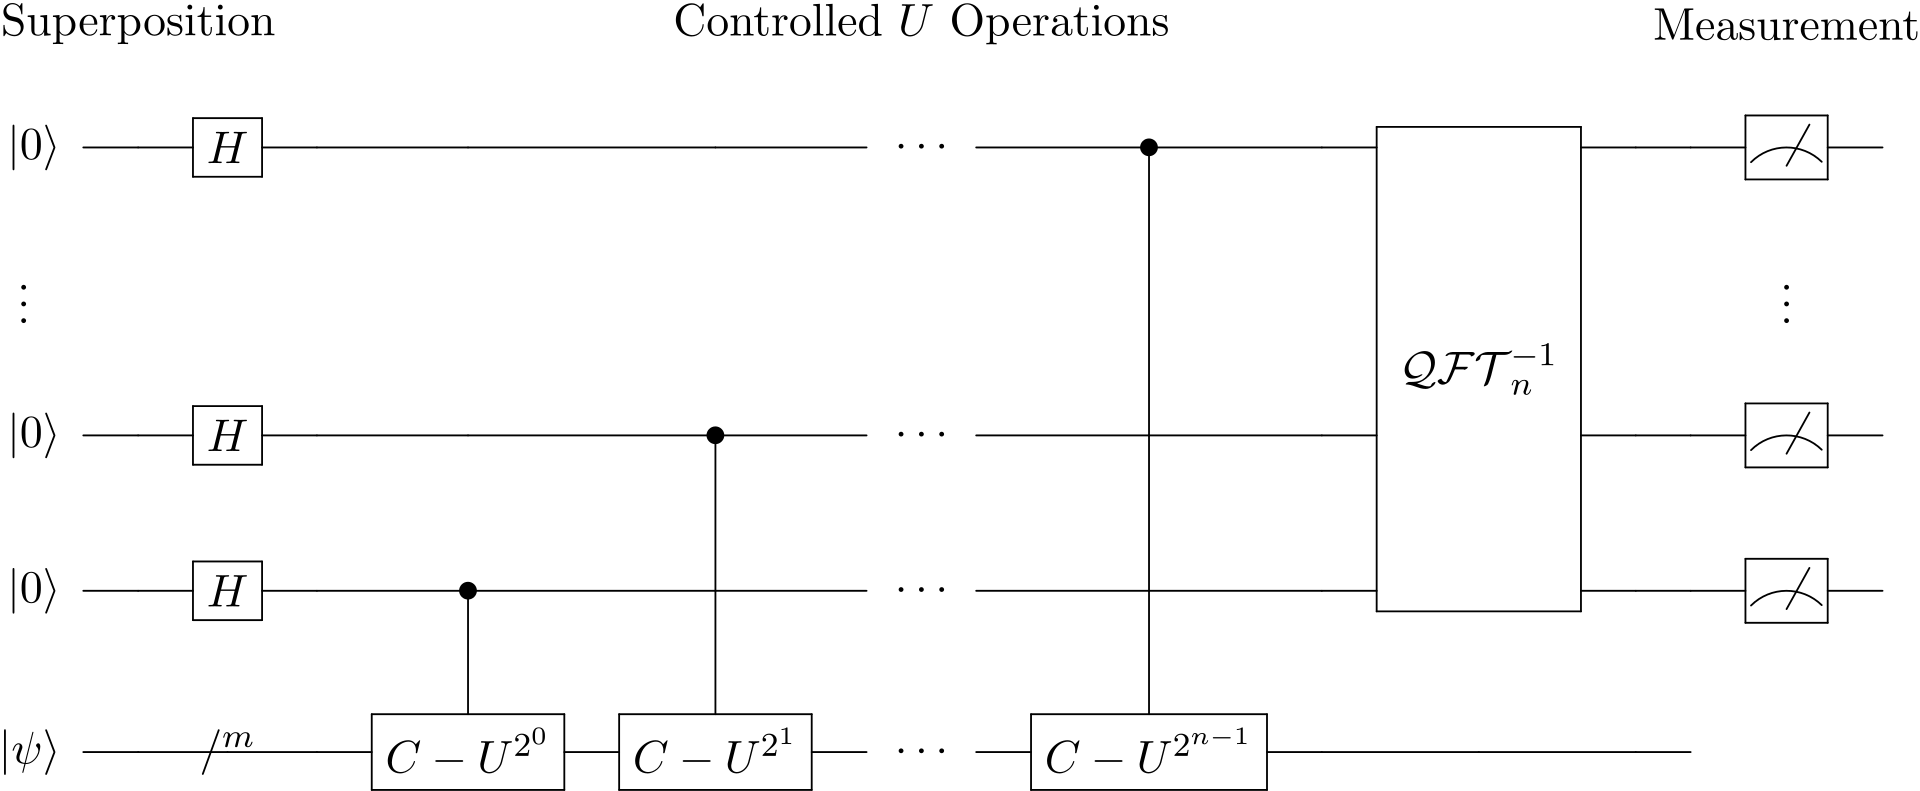

We can try this out on a 3-qubit circuit. The top two registers will contain the registers needed to perform the IQFT, while the bottom qubit will be the $|1>$ eigenstate of $P_{\theta}$:

In [324]:
'''
     ┌───┐                     │ ┌───┐                  
|0>: ┤ H ├────────■──────■─────┼─┤ H ├──■──────────────X─ (Top Register)
     ├───┤        │      │     │ └───┘  │P(-π/2) ┌───┐ │ 
|0>: ┤ H ├─■──────┼──────┼─────┼────────■────────┤ H ├─┼─ (Top Register)
     └───┘ │P(ϕ)  │P(ϕ)  │P(ϕ)│                 └───┘ │ 
|1>: ──────■──────■──────■─────┼───────────────────────X─ (Bottom Register: Eigenstate)
                               │
                               |A>
d'''
0

0

In [212]:
QS = QState(3)
QS.state={1:1}
QS.single_gate("H", 0)
QS.single_gate("H", 1)
QS.controlled_gate("P", 2, 1, var("\\phi"))
QS.controlled_gate("P", 2, 0, var("\\phi"))
QS.controlled_gate("P", 2, 0, var("\\phi"))
print("State With Phases,  |A>:")
display(QS.disp())
print("State after IQFT :")
QS.evaluate(iqft(2))
QS.disp()

State With Phases,  |A>:


(exp(3*I*\phi)*|111> + exp(2*I*\phi)*|101> + exp(I*\phi)*|011> + |001>)/2

State after IQFT :


((-I*exp(3*I*\phi) - exp(2*I*\phi) + I*exp(I*\phi) + 1)*|111> + (I*exp(3*I*\phi) - exp(2*I*\phi) - I*exp(I*\phi) + 1)*|011> + (-exp(3*I*\phi) + exp(2*I*\phi) - exp(I*\phi) + 1)*|101> + (exp(3*I*\phi) + exp(2*I*\phi) + exp(I*\phi) + 1)*|001>)/4

Note that this state is a product state with the form:
<br><br>
$$|\theta⟩ \otimes |\Lambda⟩ = \frac{\left[ (e^{i \phi}+ e^{2 i \phi}+e^{3 i \phi}+1)|00⟩  +  
(i e^{i \phi} - e^{2 i \phi} - ie^{3 i \phi} + 1)|01⟩ + (-e^{i \phi}+ e^{2 i \phi} - e^{3 i \phi}+1)|10⟩
+ (i e^{i \phi}- e^{2 i \phi} - i e^{3 i \phi}+1)|11⟩
\right] \bigotimes |1⟩}{4}$$
<br>
The phase $\phi = 2 \pi \theta$ can be estimated to an accuracy of $\frac{1}{2^{2}}$ by measuring the final state. 

If we plot out the probabilities of measuring each of the four states, we can see a few things:
<br><br>
<h5>1. The state is normalized, such that the probabilities of measuring any basis state all sum to 1, for all $\phi$. </h5>
<h5>2. The probability of measuring any particular basis state goes to 1 as $\phi$ approaches $2 \pi$ times the binary number of the state divided by 4. </h5>
    <h4>i. $P(|001⟩) \to 1$ for $\phi \to 0$</h4>
    <h4>ii. $P(|011⟩) \to 1$ for $\phi \to \frac{1}{4} 2\pi$</h4>
    <h4>iii. $P(|101⟩) \to 1$ for $\phi \to \frac{1}{2} 2\pi$</h4>
    <h4>iv. $P(|111⟩) \to 1$ for $\phi \to \frac{3}{4} 2\pi$</h4>


Text(0.5, 0, '$\\phi$')

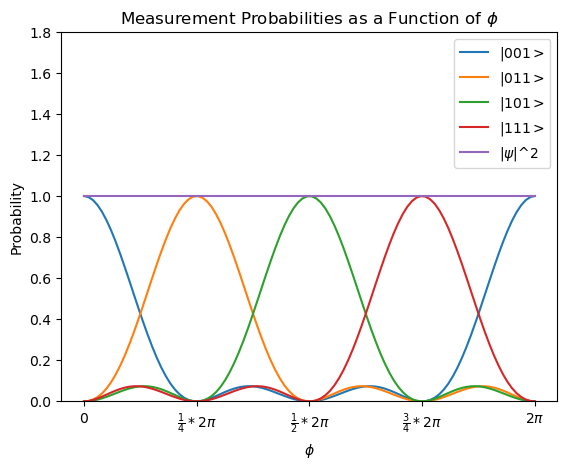

In [227]:
import matplotlib.pyplot as plt
p_space = np.linspace(0, 2*np.pi, 100)
ans_001 = lambda x: 1/4 * np.abs(np.exp(3j*x)+np.exp(2j*x)+np.exp(1j*x) + 1)
ans_101 = lambda x: 1/4 * np.abs(-np.exp(3j*x)+np.exp(2j*x)-np.exp(1j*x) + 1)
ans_011 = lambda x: 1/4 * np.abs(1j*np.exp(3j*x)-np.exp(2j*x)-1j*np.exp(1j*x) + 1)
ans_111 = lambda x: 1/4 * np.abs(-1j*np.exp(3j*x)-np.exp(2j*x)+1j*np.exp(1j*x) + 1)
plt.plot(p_space / (2*np.pi), ans_001(p_space)**2,label="$|001>$")
plt.plot(p_space / (2*np.pi), ans_011(p_space)**2,label="$|011>$")
plt.plot(p_space / (2*np.pi), ans_101(p_space)**2,label="$|101>$")
plt.plot(p_space / (2*np.pi), ans_111(p_space)**2,label="$|111>$")
plt.ylim(0, 1.8)
plt.plot(p_space / (2*np.pi), ans_001(p_space)**2 + ans_011(p_space)**2 + ans_101(p_space)**2 + ans_111(p_space)**2, label="|$\psi$|^2")
plt.legend()
plt.title("Measurement Probabilities as a Function of $\phi$")
plt.xticks([0, 1/4, 1/2, 3/4, 1], ["$0$", "$ \\frac{1}{4} * 2 \pi$", "$ \\frac{1}{2} * 2 \pi$", "$ \\frac{3}{4} * 2 \pi$", "$2 \pi$"])
plt.ylabel("Probability")
plt.xlabel("$\phi$")


For the last demonstration, we can see how the precision of the algorithm changes by increasing the number of qubits on the top register.
<br><br>
As was demonstrated with the plot using the 'Binary' module, we can get a precision of $2^{-N}$ using N qubits on the top register.
<br><br>
The following plot shows the most likely value of $\phi$ to be estimated from the QPE algorithm by varying the number of qubits on the top register (computed using my numerical QC simulation based on matrix operations):

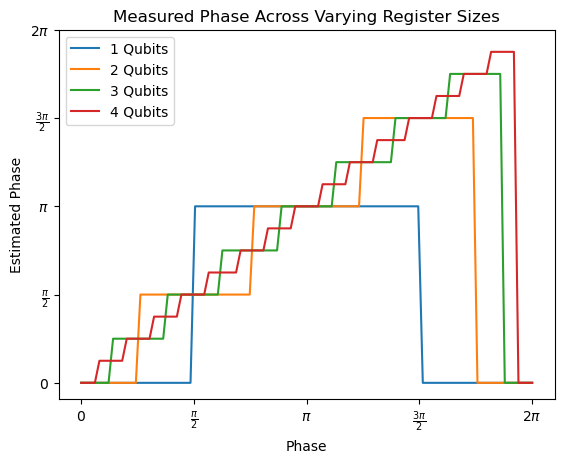